# LA-CA PART1

## Mahya Shahshahani - 810199598

In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import numpy as np
from scipy.linalg import svd

In [5]:
video_path = 'Indiantraffic.avi'

# Open the video file
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print("Error opening video file")
    exit()
    

In [6]:
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total Frames in the Video: {total_frames}")

num = 598

video.set(cv2.CAP_PROP_POS_FRAMES, num - 1)

ret, frame = video.read()

if not ret:
    print("Error: Could not read the selected frame from the video.")
    exit()


Total Frames in the Video: 901


In [7]:
fps = int(video.get(cv2.CAP_PROP_FPS))
print(fps)

20


In [8]:
#show the frame
cv2.imshow("Selected Frame", frame)
cv2.waitKey(3000)
cv2.destroyAllWindows()


In [10]:
frame.shape

(360, 640, 3)

In [11]:
#resolution of the frame
resolution_width = frame.shape[1]
resolution_height = frame.shape[0]
print(f"Resolution of the Frame: {resolution_width}x{resolution_height}")

Resolution of the Frame: 640x360


In [12]:
resolution = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print(resolution)

(640, 360)


# #gray-scale vid

In [12]:


output_path = 'output_processed_video.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 20
resolution = (int(video.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter(output_path, fourcc, fps, resolution, isColor=False)



while True:
    ret, frame = video.read()

    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Add salt and pepper noise
    noise = np.random.randint(0, 2, gray_frame.shape, dtype=np.uint8) * 255
    noisy_frame = np.where(np.random.rand(*gray_frame.shape) < 0.05, noise, gray_frame)


    out.write(noisy_frame)

video.release()
print("Processed video saved successfully.")


Processed video saved successfully.


In [13]:
import cv2

num = 0
processed_video_path = 'output_processed_video.avi'

processed_video = cv2.VideoCapture(processed_video_path)

if not processed_video.isOpened():
    print("Error opening processed video file")
    exit()

cv2.namedWindow('Processed Video', cv2.WINDOW_NORMAL)

while True:
    ret, frame = processed_video.read()
    num += 1

    if not ret:
        break

    cv2.imshow('Processed Video', frame)

    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

processed_video.release()
cv2.destroyAllWindows()

# Reopen the video to get the correct frame count
processed_video = cv2.VideoCapture(processed_video_path)
num_frames = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total number of frames in the video: {num_frames}")

processed_video.release()


Total number of frames in the video: 303


# ROBUST

In [47]:
import cv2
import numpy as np

def read_video(video_path):
    video_capture = cv2.VideoCapture(video_path)
    num_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_tensor = np.zeros((num_frames, height, width), dtype=float)

    for i in range(num_frames):
        ret, frame = video_capture.read()
        if not ret:
            print("Error reading frame")
            exit()

        # Convert the frame to grayscale (assuming it's a color frame)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        video_tensor[i] = gray_frame.astype(float)

    video_capture.release()
    return video_tensor

def So(tau, X):
    # Shrinkage operator
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0)

def Do(tau, X):
    # Shrinkage operator for singular values
    M, N, K = X.shape
    X_reshaped = X.reshape((M, N * K))
    U, S, Vt = np.linalg.svd(X_reshaped, full_matrices=False)
    S_shrink = np.maximum(S - tau, 0)
    X_hat_reshaped = U @ np.diag(S_shrink) @ Vt
    X_hat = X_hat_reshaped.reshape((M, N, K))
    return X_hat

def robust_pca(X, lambda_=None, mu=None, tol=1e-4, max_iter=1000):
    M, N, K = X.shape
    unobserved = np.isnan(X)
    X[unobserved] = 0

    if lambda_ is None:
        lambda_ = 1 / np.sqrt(max(M, N * K))
    if mu is None:
        mu = 10 * lambda_

    # Initial solution
    L = np.zeros((M, N, K))
    S = np.zeros((M, N, K))
    Y = np.zeros((M, N, K))

    # Calculate the norm for each frame
    norm_frames = np.linalg.norm(X, axis=(1, 2))

    for iteration in range(1, max_iter + 1):
        # ADMM step: update L and S
        L = Do(1 / mu, X - S + (1 / mu) * Y)
        S = So(lambda_ / mu, X - L + (1 / mu) * Y)
        # And augmented Lagrangian multiplier
        Z = X - L - S
        Z[unobserved] = 0  # Skip missing values
        Y = Y + mu * Z

        # Calculate the frobenius norm using individual frame norms
        err = np.linalg.norm(Z, axis=(1, 2)) / norm_frames
        if iteration == 1 or iteration % 10 == 0 or np.all(err < tol):
            print(f'iter: {iteration:04d}\terr: {err.mean()}\trank(L): {np.linalg.matrix_rank(L)}\tcard(S): {np.count_nonzero(~unobserved)}')
        if np.all(err < tol):
            break

    return L, S


processed_video_path = 'output_processed_video.avi'
video_data = read_video(processed_video_path)

lambda_val = 1 / np.sqrt(np.max(video_data.shape))
L, S = robust_pca(video_data, lambda_val/100, 10*lambda_val/100, 1e-5)


iter: 0001	err: 0.0010265402073927664	rank(L): [360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360

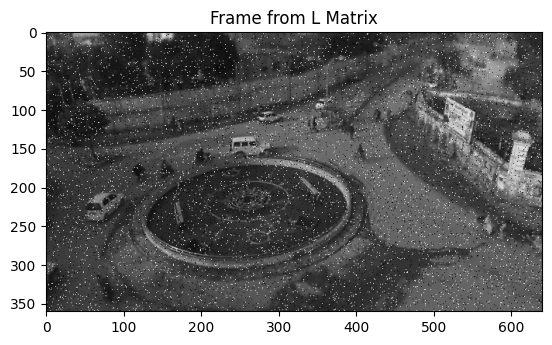

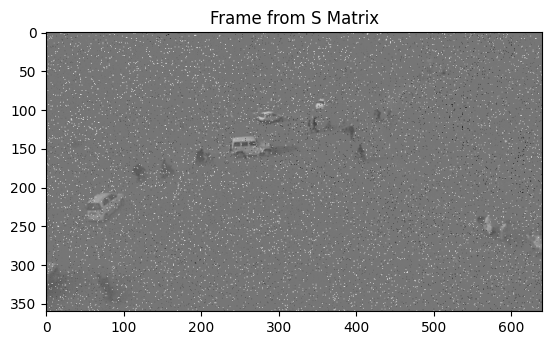

In [48]:
import cv2
import matplotlib.pyplot as plt


frame_index = 5


frame_L = L[frame_index]
frame_S = S[frame_index]

# matrix L
plt.imshow(frame_L, cmap='gray')
plt.title('Frame from L Matrix')
plt.show()

# matrix S
plt.imshow(frame_S, cmap='gray')
plt.title('Frame from S Matrix')
plt.show()


In [148]:
low_rank.shape

(303, 230400)

In [149]:
sparse.shape

(303, 230400)

In [150]:
tensor.shape

(303, 360, 640)

In [151]:
reconstructed_tensor.shape
tensor.shape

(303, 360, 640)

# Reconstruction Error for each frame

In [152]:
reconstruction_error = np.linalg.norm(tensor - reconstructed_tensor, 'fro', axis=(1, 2)) / np.linalg.norm(tensor, 'fro', axis=(1, 2))
print(f"Reconstruction Error: {reconstruction_error}")


Reconstruction Error: [9.29110480e-05 9.28608441e-05 9.30947480e-05 9.29335775e-05
 9.30082611e-05 9.31671004e-05 9.36056475e-05 9.35614773e-05
 9.43328262e-05 9.45173657e-05 9.43497903e-05 9.43997551e-05
 9.31083419e-05 9.40883312e-05 9.40642048e-05 9.29862247e-05
 9.34782331e-05 9.30817394e-05 9.32032955e-05 9.32662398e-05
 9.32857981e-05 9.30426117e-05 9.29083215e-05 9.29955658e-05
 9.29201031e-05 9.27077986e-05 9.26389013e-05 9.23600909e-05
 9.20524614e-05 9.20006447e-05 9.19060415e-05 9.16762677e-05
 9.20015534e-05 9.29899087e-05 9.36210514e-05 9.37632532e-05
 9.33756771e-05 9.35824494e-05 9.32348107e-05 9.32866506e-05
 9.32773395e-05 9.33928613e-05 9.36115240e-05 9.35533497e-05
 9.36812254e-05 9.34608525e-05 9.30375577e-05 9.27794544e-05
 9.22842029e-05 9.20127159e-05 9.18021865e-05 9.21383683e-05
 9.21315869e-05 9.21731108e-05 9.31774578e-05 9.23467284e-05
 9.24940245e-05 9.36861348e-05 9.27249802e-05 9.39154065e-05
 9.35909711e-05 9.37359172e-05 9.25189632e-05 9.39646046e-05
 9

In [154]:

processed_video_path = 'output_processed_video.avi'

processed_video = cv2.VideoCapture(processed_video_path)

if not processed_video.isOpened():
    print("Error opening processed video file")
    exit()


num_frames = int(processed_video.get(cv2.CAP_PROP_FRAME_COUNT))

frames = num_frames

tensor = np.zeros((frames, height, width))
for i in range(frames):
    ret, frame = processed_video.read()
    if not ret:
        print("Error reading frame from processed video")
        exit()
    tensor[i] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)

low_rank_tensor, sparse_tensor, reconstructed_tensor = robust_pca_3d(tensor)

low_rank_tensor = low_rank_tensor.reshape((frames, height, width))
sparse_tensor = sparse_tensor.reshape((frames, height, width))
reconstructed_tensor = reconstructed_tensor.reshape((frames, height, width))

# reconstruction_error = np.linalg.norm(tensor - reconstructed_tensor, 'fro') / np.linalg.norm(tensor, 'fro')
# print(f"Reconstruction Error: {reconstruction_error}")


foreground_video_path = 'foreground.avi'
background_video_path = 'background.avi'

foreground_video = cv2.VideoWriter(foreground_video_path, cv2.VideoWriter_fourcc(*'XVID'), 20, (width, height), isColor=False)
background_video = cv2.VideoWriter(background_video_path, cv2.VideoWriter_fourcc(*'XVID'), 20, (width, height), isColor=False)




In [155]:

threshold = 10


for i in range(frames):
    frame_low_rank = low_rank_tensor[i].astype(np.uint8)
    frame_sparse = sparse_tensor[i].astype(np.uint8)

    foreground_mask = frame_sparse > threshold

    
    frame_foreground = np.zeros_like(tensor[i])
    frame_foreground[foreground_mask] = tensor[i][foreground_mask]


    frame_background = frame_low_rank.copy()
    frame_background[~foreground_mask] = 0


    foreground_video.write(frame_foreground)
    background_video.write(frame_background)

processed_video.release()
foreground_video.release()
background_video.release()

print("Videos saved successfully.")



Videos saved successfully.
